In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# WindNinja mean 2015 wind speed

In [2]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc"
ds_wn = xr.open_dataset(path)
n_trim = 15 # 15
ds_wn = ds_wn.isel(easting=slice(n_trim, -n_trim))
ds_wn = ds_wn.isel(northing=slice(n_trim, -n_trim))
wn_ws = ds_wn['ws'].mean(dim='time')
wn_ws_map = ds_wn['ws'][11::12,:,:].mean(dim='time')

In [22]:
wn_ws_map.mean()

<xarray.DataArray 'ws' ()>
array(6.511971, dtype=float32)

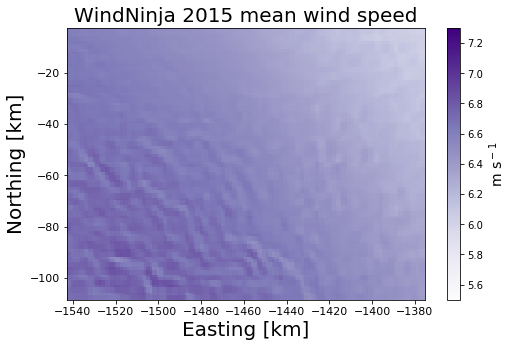

In [3]:
colormap = Purples_9.mpl_colormap

plt.figure(figsize=(8, 5))
plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, wn_ws_map, cmap=colormap, vmin=5.5, vmax=7.3, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("WindNinja 2015 mean wind speed", fontsize=20)
plt.savefig("images/WN_ws.pdf", format='pdf', dpi=100, bbox_inches='tight')

# Liston mean 2015 wind speed

In [4]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_Liston/output/grids/a3d_grids_2015.nc"
ds_l = xr.open_dataset(path)
n_trim = 15 # 15
ds_l = ds_l.isel(easting=slice(n_trim, -n_trim))
ds_l = ds_l.isel(northing=slice(n_trim, -n_trim))
l_ws = ds_l['ws'].mean(dim='time')
l_ws_map = ds_l['ws'][11::12,:,:].mean(dim='time')

In [23]:
l_ws_map.mean()

<xarray.DataArray 'ws' ()>
array(6.1429996, dtype=float32)

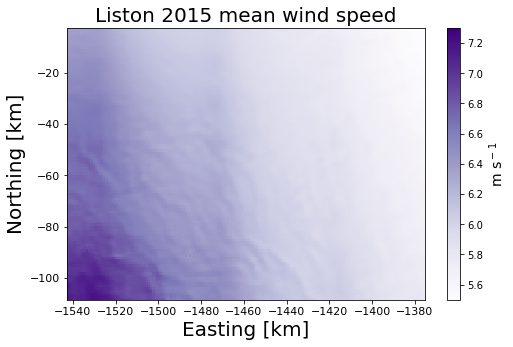

In [5]:
colormap = Purples_9.mpl_colormap

plt.figure(figsize=(8, 5))
plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, l_ws_map, cmap=colormap, vmin=5.5, vmax=7.3, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("Liston 2015 mean wind speed", fontsize=20)
plt.savefig("images/Liston_ws.pdf", format='pdf', dpi=100, bbox_inches='tight')

# WindNinja minus Liston

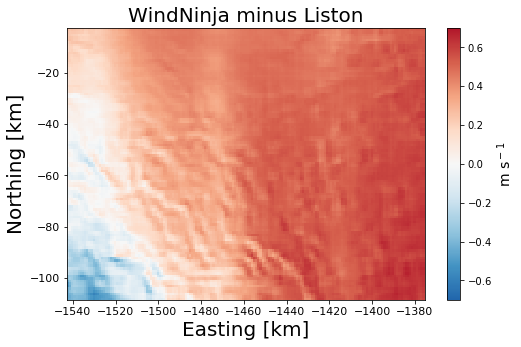

In [6]:
colormap = RdBu_9.mpl_colormap.reversed()

plt.figure(figsize=(8, 5))
plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, wn_ws_map - l_ws_map, cmap=colormap, vmin=-0.7, vmax=0.7, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("WindNinja minus Liston", fontsize=20)
plt.savefig("images/WN-Liston_ws.pdf", format='pdf', dpi=100, bbox_inches='tight')

# MERRA-2 mean 2015 wind speed (see notebook from `Figure1.ipynb`)

In [7]:
M2 = xr.open_dataset("nc_files/M2_processed.nc")
M2_ws = M2['Wind Speed'].mean(dim='time')

In [24]:
M2_ws.mean()

<xarray.DataArray 'Wind Speed' ()>
array(6.57209142)

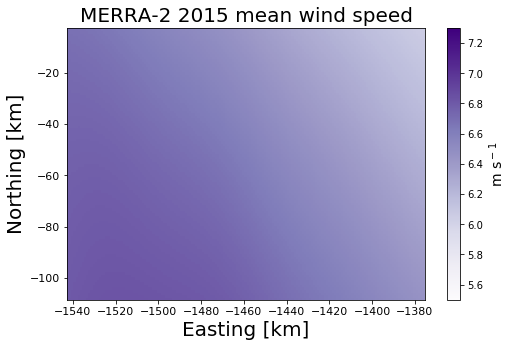

In [8]:
colormap = Purples_9.mpl_colormap

plt.figure(figsize=(8, 5))
plt.pcolor(ds_wn['easting']/1000, ds_wn['northing']/1000, M2_ws.values, cmap=colormap, vmin=5.5, vmax=7.3, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.set_label("m s$^-$$^1$", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("MERRA-2 2015 mean wind speed", fontsize=20)
plt.savefig("images/M2_wind_speed.pdf", format='pdf', dpi=100, bbox_inches='tight')


# Transect

In [9]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [10]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [11]:
domain_left = ds_l['easting'].min()
domain_right = ds_l['easting'].max()
domain_bottom = ds_l['northing'].min()
domain_top = ds_l['northing'].max()

In [12]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [13]:
# Load DEM
dem = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/dem.asc", skiprows=6))
dem = dem[n_trim:-n_trim, n_trim:-n_trim]
dem = xr.DataArray(dem, coords=[ds_l['northing'], ds_l['easting']], dims=['northing', 'easting'])

# Load slope
slope = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/slope.asc", skiprows=6))
slope = slope[n_trim:-n_trim, n_trim:-n_trim]
slope = xr.DataArray(slope, coords=[ds_l['northing'], ds_l['easting']], dims=['northing', 'easting'])

In [14]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

Liston_transect =  l_ws.sel(northing=tgt_y, easting=tgt_x, method='nearest')
WN_transect =  wn_ws.sel(northing=tgt_y, easting=tgt_x, method='nearest')
DEM_transect =  dem.sel(northing=tgt_y, easting=tgt_x, method='nearest')
slope_transect =  slope.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [15]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

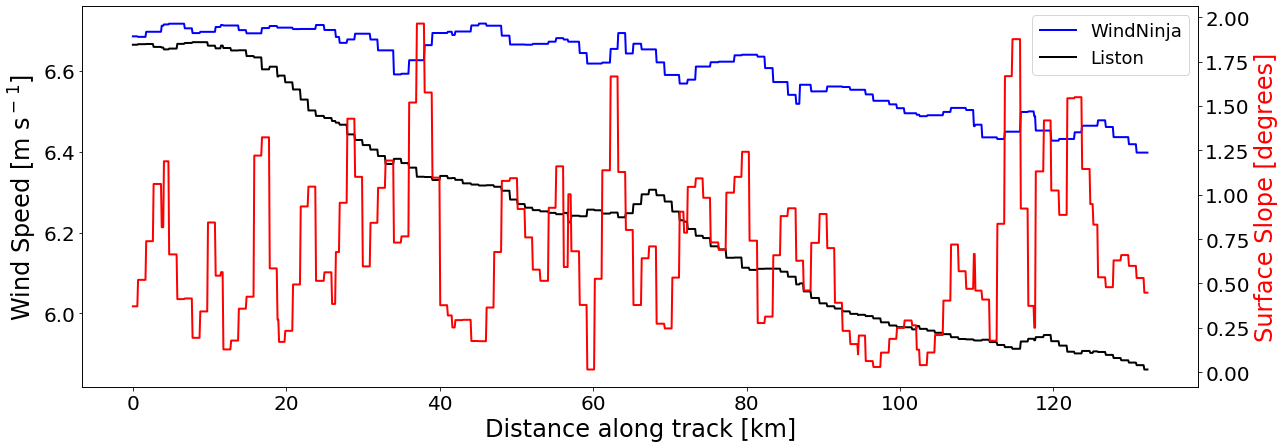

In [16]:
fig, ax1 = plt.subplots(figsize=(20,7))

ax2 = ax1.twinx()
ax1.plot(dat, WN_transect[indices], 'b', label='WindNinja', linewidth=2)
ax1.plot(dat, Liston_transect[indices], 'k', label='Liston', linewidth=2)
ax1.legend(fontsize=18)
ax2.plot(dat, slope_transect[indices], 'r', label='Slope', linewidth=2)

ax1.set_xlabel("Distance along track [km]", color='k', fontsize=24)
ax1.set_ylabel("Wind Speed [m s$^-$$^1$]", color='k', fontsize=24)
ax2.set_ylabel("Surface Slope [degrees]", color='r', fontsize=24)

for label in ax1.xaxis.get_majorticklabels():
    label.set_fontsize(20)
for label in ax1.yaxis.get_majorticklabels():
    label.set_fontsize(20)
for label in ax2.yaxis.get_majorticklabels():
    label.set_fontsize(20)

plt.savefig("images/wind_compare.pdf", format='pdf', dpi=100, bbox_inches='tight')
plt.show()


In [17]:
obs_X[indices[0]]/1000

-1541.6492734077194

In [18]:
obs_X[indices[-1]]/1000

-1410.5627015319242

In [19]:
obs_Y[indices[0]]/1000

-41.46878911461473

In [20]:
obs_Y[indices[-1]]/1000

-58.93999120956787